# E.17. 난 스케치를 할 테니 너는 채색을 하거라
- Tensorflow의 Subclassing API로 레이어 및 모델을 구성하는 방법
- 신경망의 학습 방법
- CNN, GAN에 대한 기본적인 개념
- Tensorflow의 GradientTape API를 이용한 학습 코드를 보고 이해
- **(중요)** Tensorflow 내에서 잘 모르는 함수(또는 메서드)를 발견했을 때, 공식 문서에서 검색하고 이해해 보려는 의지가 필요합니다.

#### 목차 (순서)
1. 조건 없는 생성 모델(Unconditional Generative Model), GAN
2. 조건 있는 생성 모델(Conditional Generative Model), cGAN
3. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기
4. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기
5. 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기
6. GAN의 입력에 이미지를 넣는다면? Pix2Pix
7. 난 스케치를 할 테니 너는 채색을 하거라 (1) 데이터 준비하기
8. 난 스케치를 할 테니 너는 채색을 하거라 (2) Generator 구성하기
9. 난 스케치를 할 테니 너는 채색을 하거라 (3) Generator 재구성하기
10. 난 스케치를 할 테니 너는 채색을 하거라 (4) Discriminator 구성하기
11. 난 스케치를 할 테니 너는 채색을 하거라 (5) 학습 및 테스트하기
12. 프로젝트 : Segmentation map으로 도로 이미지 만들기


## 0.  데이터 준비

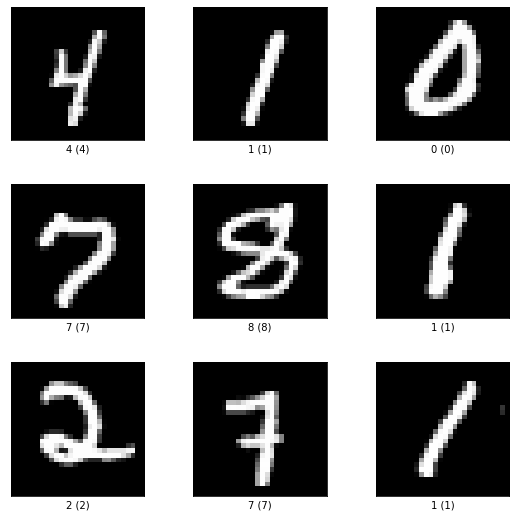

In [4]:
# tensorflow-datasets 라이브러리에서 간단하게 MNIST 데이터셋 확인

import tensorflow_datasets as tfds

mnist, info =  tfds.load("mnist", split="train", with_info=True)

fig = tfds.show_examples(mnist, info)

In [5]:
# 이미지 픽셀 값을 -1~1 사이의 범위로 변경했고
# 레이블 정보를 원-핫 인코딩(one-hot encoding)함.
# GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 
# gan_preprocessing()과 cgan_preprocessing() 두 가지 함수를 구성

import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)
print("✅")


✅


Label : tf.Tensor([0. 0. 0. 0. 1. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


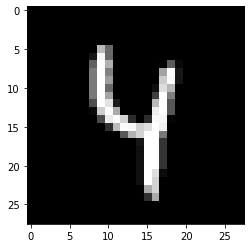

In [6]:
# 확인 
# 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 합

import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

## 17-4. 내가 원하는 숫자 이미지 만들기 (1) Generator 구성하기
**Tensorflow2의 Subclassing 방법을 이용**


Subclassing 방법은<br>
1. tensorflow.keras.Model 을 상속받아 클래스를 만들며, 
2. 일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고, 
3. 구성된 레이어를 call() 메서드에서 사용해 **forward propagation**을 진행한다.

### GAN의 Generator를 아래와 같이 구현

In [7]:
# GAN의 Generator를 아래와 같이 구현

from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

print("✅")

✅


### cGAN의 Generator를 아래와 같이 구현

In [8]:
#  cGAN의 Generator 구현

class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)
    
print("✅")

✅


## 17-5. 내가 원하는 숫자 이미지 만들기 (2) Discriminator 구성하기

### GAN Discriminator 구성하기

In [9]:
# Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이며, 
# 이를 fully-connected 레이어로 학습하기 위해 call()에서는 
# 가장 먼저 layers.Flatten()이 적용됩니다.

class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x
    
print("✅")

✅


### cGAN Discriminator 구성하기

In [10]:
# Maxout을 구성
# Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, 
# units 차원 수를 가진 fully-connected 레이어를 pieces개만큼 만들고 
# 그중 최댓값을 출력합니다

class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=2)

print("✅")

✅


In [11]:
# 위에서 정의한 Maxout 레이어를 3번만 사용하면 
# 아래와 같이 쉽게 cGAN의 Discriminator를 구성할 수 있습니다.

# GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용됩니다

class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)          # 결과 차원수 : 240
        label = self.label_block(label)          # 결과 차원수 : 50
        x = layers.Concatenate()([image, label]) # 결과 차원수 : 240
        x = self.combine_block(x)
        return self.dense(x)
    
print("✅")


✅


## 17-6. 내가 원하는 숫자 이미지 만들기 (3) 학습 및 테스트하기

GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 
- loss function: 진짜 및 가짜를 구별하기 위해 **Binary Cross Entropy**
- optimizer: **Adam optimizer**

In [12]:
# Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해 보자
    
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)

disc_opt = optimizers.Adam(1e-4)    

print("✅")

✅


### GAN으로 MNIST 학습하기 !!!!!!!!

In [13]:
# GAN으로 MNIST 학습하기 !!!!!!!!

gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

print("✅")

✅


In [14]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.2183022499084473, D:0.13821351528167725
[1/10 EPOCHS, 200 ITER] G:2.41024112701416, D:0.11481503397226334
[1/10 EPOCHS, 300 ITER] G:2.3472843170166016, D:0.1429361253976822
[1/10 EPOCHS, 400 ITER] G:3.325523853302002, D:0.12933003902435303
[2/10 EPOCHS, 100 ITER] G:3.466015577316284, D:0.1104256883263588
[2/10 EPOCHS, 200 ITER] G:2.7406859397888184, D:0.3212355077266693
[2/10 EPOCHS, 300 ITER] G:5.288262367248535, D:0.06463442742824554
[2/10 EPOCHS, 400 ITER] G:2.824719190597534, D:0.15184466540813446
[3/10 EPOCHS, 100 ITER] G:3.5335168838500977, D:0.12538489699363708
[3/10 EPOCHS, 200 ITER] G:2.826632499694824, D:0.11973892897367477
[3/10 EPOCHS, 300 ITER] G:3.5472421646118164, D:0.36146116256713867
[3/10 EPOCHS, 400 ITER] G:3.954458713531494, D:0.05126112699508667
[4/10 EPOCHS, 100 ITER] G:3.7072436809539795, D:0.15547022223472595
[4/10 EPOCHS, 200 ITER] G:3.7584965229034424, D:0.05996841937303543
[4/10 EPOCHS, 300 ITER] G:2.843447208404541, D:0.2559352517

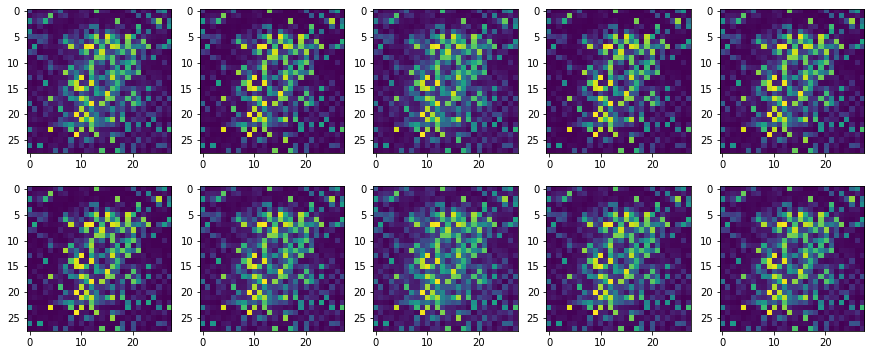

In [15]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

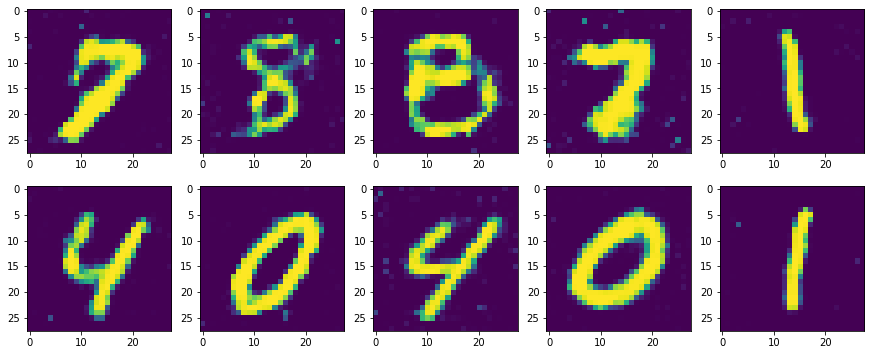

In [16]:
# 위의 결과를 보니 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없나 봅니다.
# 위 구현을 그대로 500 epoch 학습한 가중치를 준비해 두었으니 한번 사용해 봅시다

import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

### cGAN으로 MNIST 학습하기 !!!!!!!!

In [17]:
# cGAN으로 MNIST 학습하기 !!!!!!!!

cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.349109649658203, D:0.0062613459303975105
[1/1 EPOCHS, 199 ITER] G:4.999909400939941, D:0.03311033174395561
[1/1 EPOCHS, 299 ITER] G:4.792959213256836, D:0.031604114919900894
[1/1 EPOCHS, 399 ITER] G:4.055728912353516, D:0.04834749549627304


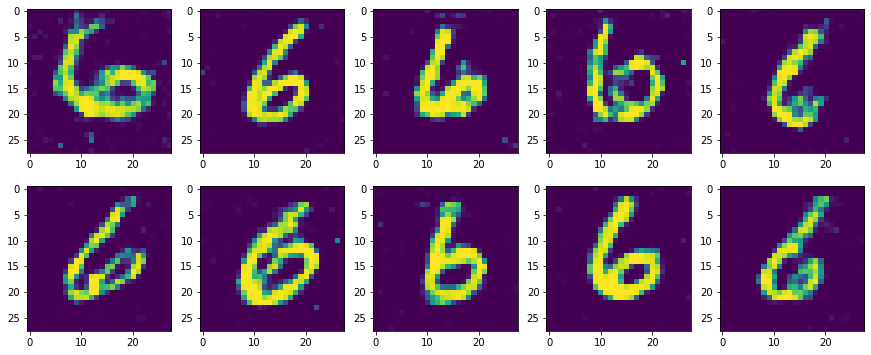

In [18]:
number =   6 # TODO : 생성할 숫자를 입력해 주세요!!

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

## 17-7. GAN의 입력에 이미지를 넣는다면? Pix2Pix